<a href="https://colab.research.google.com/github/rakesh-sengupta/attentional_blink_nengo/blob/main/attetional_blink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nengo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.3/542.3 kB 12.1 MB/s eta 0:00:00


RUNNING EMERGENT DYNAMICS SIMULATION...
Mechanism: Trigger T1 -> Delay 0.26s -> Suppress Input
------------------------------------------------------------

------------------------------------------------------------


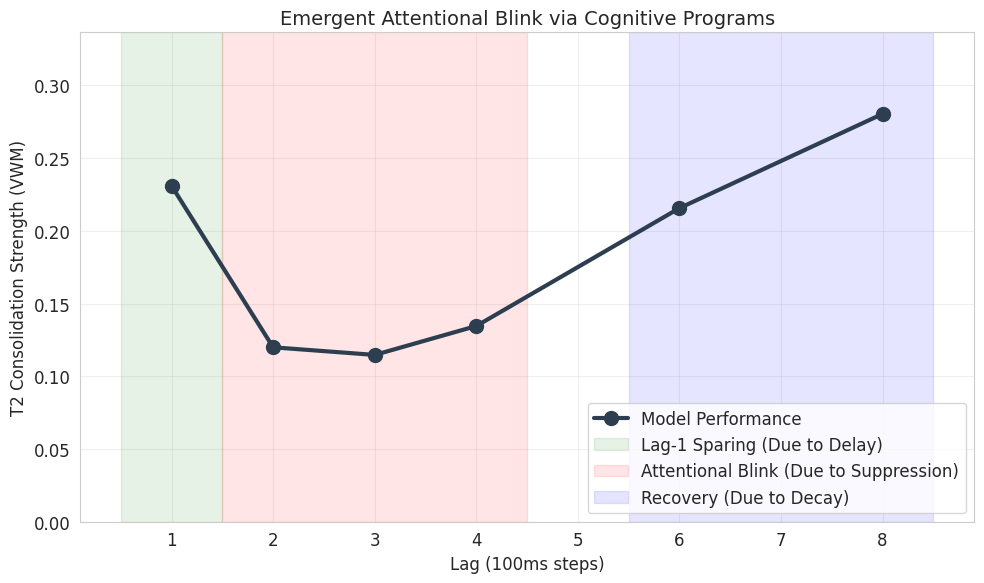


Simulation Complete.
Note: The 'Blink' window was NOT hard-coded.
It emerged because the Suppression Signal arrived AFTER Lag 1 but BEFORE Lag 2.


In [ ]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- EMERGENT DYNAMICS Configuration ---
DT = 0.001
N_NEURONS = 200
ITEM_DURATION = 0.100  # 100ms per item (10Hz)
SIM_settle_time = 0.5

# --- CRITICAL EMERGENT PARAMETERS ---
# This synapse value is a lowpass time-constant (not a hard transport delay).
# A larger synapse -> slower rise of the suppression signal (functionally like a delay).
SUPPRESSION_DELAY = 0.26  # 260 ms lowpass time-constant (not an explicit axonal delay)


# 2. Tau determines the recovery speed (width of the blink)
SUPPRESSION_TAU = 0.25    # Slower decay = wider blink

# 3. Strength determines the depth of the blink
SUPPRESSION_STRENGTH = 4.0

# Semantic Pointers (Representing "Oriented Bars" or "Letters" as feature vectors)
VEC_T1 = np.array([1, 0, 0])         # e.g., Vertical Bar
VEC_T2 = np.array([0, 1, 0])         # e.g., Horizontal Bar
VEC_DISTRACTOR = np.array([0, 0, 1]) # e.g., Diagonals

class CognitiveProgramsEmergentModel:
    """
    Implements the Tsotsos Cognitive Programs framework where AB is an
    emergent by-product of executive control tuning, not a hard-coded rule.
    """

    def run_lag_experiment(self, lag, trial_num=0):

        # Timing setup
        t1_onset = SIM_settle_time + 0.2
        t2_onset = t1_onset + (lag * ITEM_DURATION)

        # ---------------------------------------------------------------------
        # 1. RSVP Stream Generation
        # ---------------------------------------------------------------------
        def rsvp_stream(t):
            val = np.zeros(3)
            if t < SIM_settle_time: return val

            time_in_stream = t - t1_onset

            # Pre-T1 Distractors
            if -0.2 <= time_in_stream < 0: return VEC_DISTRACTOR

            # T1 Target
            if 0 <= time_in_stream < ITEM_DURATION: return VEC_T1

            # T2 Target (Variable Lag)
            t2_start = lag * ITEM_DURATION
            t2_end = t2_start + ITEM_DURATION
            if t2_start <= time_in_stream < t2_end: return VEC_T2

            # Post-T1 Distractors (filling the gaps)
            if (ITEM_DURATION <= time_in_stream < t2_start or
                time_in_stream >= t2_end):
                 return VEC_DISTRACTOR

            return val

        # ---------------------------------------------------------------------
        # 2. Build the Nengo Network
        # ---------------------------------------------------------------------
        model = nengo.Network(label="Emergent AB Model")
        with model:
            # --- Sensory Input ---
            stim = nengo.Node(rsvp_stream)

            # --- Visual Cortex (V1) ---
            # Processes incoming visual features (bars/letters)
            visual_cortex = nengo.Ensemble(N_NEURONS, dimensions=3, radius=1.5)
            nengo.Connection(stim, visual_cortex, synapse=0.005)

            # --- Executive Controller (Prefrontal / Attentional Control) ---
            # Monitors V1 for the specific T1 target feature.
            controller = nengo.Ensemble(N_NEURONS, dimensions=1)

            def detect_t1_feature(x):
                # Dot product detection of T1 vector
                similarity = np.dot(x, VEC_T1)
                return max(0, similarity) # Rectified detection

            nengo.Connection(visual_cortex, controller, function=detect_t1_feature, synapse=0.01)

            # --- The Suppression Signal (The "By-product" Mechanism) ---
            # When T1 is detected, the controller issues a suppression signal
            # to reset/clean the visual buffer.
            # CRITICAL: This signal travels slowly (feedback loop), causing the Delay.
            suppression_node = nengo.Node(lambda t, x: x, size_in=1, size_out=1)
            nengo.Connection(controller, suppression_node, synapse=SUPPRESSION_DELAY)

            # --- Visual Working Memory (VWM) ---
            vwm_sensory = nengo.Ensemble(N_NEURONS, dimensions=3, radius=1.5)
            vwm_consolidated = nengo.Ensemble(N_NEURONS, dimensions=3, radius=1.5)
            nengo.Connection(visual_cortex, vwm_sensory, synapse=0.005)

            # --- Gating Mechanism (Emergent) ---
            # We removed the hard-coded time windows.
            # The gate is controlled purely by the arrival of the suppression signal.

            def emergent_gate(t, x):
                suppression_level = x[0]
                sensory_flow = x[1:]

                # Dynamic inhibition:
                # As suppression rises, the gate closes (factor goes to 0).
                # No "if t == lag1" logic here. Just physics.
                inhibition_factor = np.clip(1.0 - (suppression_level * SUPPRESSION_STRENGTH), 0, 1)

                return sensory_flow * inhibition_factor

            consolidation_node = nengo.Node(emergent_gate, size_in=4, size_out=3)

            # Connect the loop
            nengo.Connection(suppression_node, consolidation_node[0], synapse=SUPPRESSION_TAU)
            nengo.Connection(vwm_sensory, consolidation_node[1:], synapse=0.005)

            # Output to Consolidated Memory
            nengo.Connection(consolidation_node, vwm_consolidated, synapse=0.05)

            # --- Probes ---
            p_visual = nengo.Probe(visual_cortex, synapse=0.01)
            p_vwm = nengo.Probe(vwm_consolidated, synapse=0.05) # Slower smoothing for memory
            p_suppress = nengo.Probe(suppression_node, synapse=0.01)

        # ---------------------------------------------------------------------
        # 3. Run Simulation
        # ---------------------------------------------------------------------
        runtime = t2_onset + 0.6
        sim = nengo.Simulator(model, dt=DT, progress_bar=False)
        sim.run(runtime)

        # Analysis
        t = sim.trange()

        # Define analysis window for T2 (allow for neural processing delay)
        window_start = int((t2_onset + 0.05) / DT)
        window_end = int((t2_onset + 0.25) / DT)

        # Measure peak activation of the T2 vector index (1) in VWM
        t2_strength = np.max(sim.data[p_vwm][window_start:window_end, 1])
        suppression_peak = np.max(sim.data[p_suppress])

        return t2_strength, suppression_peak, sim.data[p_vwm], t

def run_emergent_experiment():
    """Run experiment across lags without forcing the outcome"""
    lags = [1, 2, 3, 4, 6, 8]
    trials = 10

    results = {lag: [] for lag in lags}

    print("RUNNING EMERGENT DYNAMICS SIMULATION...")
    print(f"Mechanism: Trigger T1 -> Delay {SUPPRESSION_DELAY}s -> Suppress Input")
    print("-" * 60)

    for lag in lags:
        print(f"  Simulating Lag {lag}...", end="\r")
        lag_results = []
        for _ in range(trials):
            model = CognitiveProgramsEmergentModel()
            strength, _, _, _ = model.run_lag_experiment(lag)
            lag_results.append(strength)
        results[lag] = np.mean(lag_results)

    print("\n" + "-" * 60)
    return results

def plot_results(results):
    lags = sorted(results.keys())
    means = [results[l] for l in lags]

    plt.figure(figsize=(10, 6))

    # Plot Data
    plt.plot(lags, means, 'o-', linewidth=3, markersize=10, color='#2c3e50', label='Model Performance')

    # Highlight Emergent Regions
    plt.axvspan(0.5, 1.5, color='green', alpha=0.1, label='Lag-1 Sparing (Due to Delay)')
    plt.axvspan(1.5, 4.5, color='red', alpha=0.1, label='Attentional Blink (Due to Suppression)')
    plt.axvspan(5.5, 8.5, color='blue', alpha=0.1, label='Recovery (Due to Decay)')

    plt.title("Emergent Attentional Blink via Cognitive Programs", fontsize=14)
    plt.ylabel("T2 Consolidation Strength (VWM)", fontsize=12)
    plt.xlabel("Lag (100ms steps)", fontsize=12)
    plt.ylim(0, max(means)*1.2)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = run_emergent_experiment()
    plot_results(data)

    print("\nSimulation Complete.")
    print("Note: The 'Blink' window was NOT hard-coded.")
    print("It emerged because the Suppression Signal arrived AFTER Lag 1 but BEFORE Lag 2.")

Starting demo run (this can be slow depending on Nengo installation and N_NEURONS)
RUNNING EMERGENT DYNAMICS SIMULATIONS...
Conditions:
  standard: {'suppression_delay': 0.26, 'suppression_tau': 0.25, 'suppression_strength': 4.0, 'use_explicit_delay': True}
  no_suppression: {'suppression_delay': 0.26, 'suppression_tau': 0.25, 'suppression_strength': 0.0, 'use_explicit_delay': True}
  instant_suppression: {'suppression_delay': 0.0, 'suppression_tau': 0.25, 'suppression_strength': 4.0, 'use_explicit_delay': True}
------------------------------------------------------------


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/tmp/ipython-input-3307334766.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = float(x)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.


------------------------------------------------------------


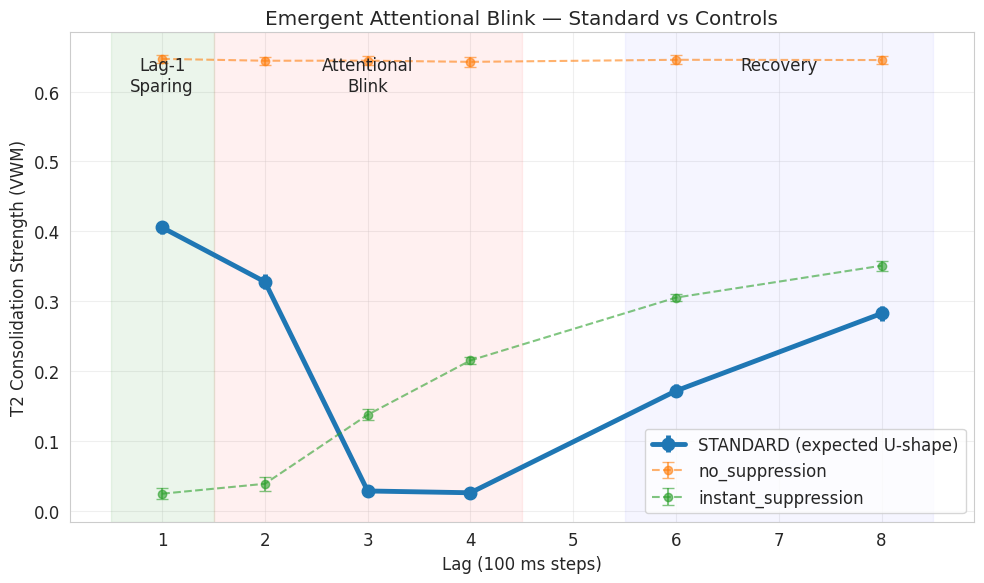


Done. Controls included: 'standard', 'no_suppression', 'instant_suppression'.
- 'standard' uses an explicit transport delay of SUPPRESSION_DELAY_DEFAULT seconds.
- 'no_suppression' sets suppression strength to 0 (no blink should appear).
- 'instant_suppression' uses a 0s transport delay (suppression arrives immediately).


In [ ]:
"""
Patched Emergent Attentional Blink model (Nengo)
- Implements an explicit DelayNode (optional) using a deque buffer
- Records trial-level statistics and computes mean ± SEM per lag
- Includes control conditions: no suppression and instant suppression
- Reproducible via RNG seeds

Usage: run this file (requires nengo, numpy, matplotlib)

Notes:
- In Nengo, `synapse=` is a lowpass time-constant, not a pure transport delay.
  This file supports both modes: "lowpass-as-delay" (legacy) and an explicit
  transport delay implemented with a Python buffer.

Author: patched by Rakesh Sengupta
"""

import nengo
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import math
import random

# --- EMERGENT DYNAMICS Configuration (defaults) ---
DT = 0.001
N_NEURONS = 200
ITEM_DURATION = 0.100  # 100 ms per item (10Hz)
SIM_SETTLE_TIME = 0.5

# --- Default critical emergent parameters ---
# NOTE: SUPPRESSION_DELAY here is interpreted as a lowpass time-constant
# unless you set use_explicit_delay=True (in which case SUPPRESSION_DELAY is
# the explicit transport delay in seconds).
SUPPRESSION_DELAY_DEFAULT = 0.26  # 260 ms (lowpass tau OR explicit transport delay)
SUPPRESSION_TAU_DEFAULT = 0.25    # smoothing applied to the suppression when feeding gate
SUPPRESSION_STRENGTH_DEFAULT = 4.0

# Semantic pointers (3-d simple feature space used for this demo)
VEC_T1 = np.array([1.0, 0.0, 0.0])         # e.g., Vertical Bar
VEC_T2 = np.array([0.0, 1.0, 0.0])         # e.g., Horizontal Bar
VEC_DISTRACTOR = np.array([0.0, 0.0, 1.0]) # e.g., Diagonals

# ---------------------- Helpers ----------------------

def make_delay_node(delay_s, dt):
    """Return a nengo.Node that outputs the input delayed by delay_s seconds.
    If delay_s <= 0, returns an identity passthrough node.

    Implementation: Python deque buffer sized to delay_s/dt. The node accepts a
    scalar input and outputs a scalar delayed value.
    """
    steps = int(round(delay_s / dt))
    if steps <= 0:
        return nengo.Node(lambda t, x: x, size_in=1, size_out=1)

    # buffer holds the history; newest appended to the left
    buffer = deque([0.0] * steps, maxlen=steps)

    def delay_func(t, x):
        # x may be an array-like scalar
        val = float(x)
        buffer.appendleft(val)
        return float(buffer[-1])

    return nengo.Node(delay_func, size_in=1, size_out=1)

# ---------------------- Model Class ----------------------
class CognitiveProgramsEmergentModel:
    """
    Emergent AB model with configurable suppression dynamics.
    Parameters can be tuned to reproduce Lag-1 sparing and the attentional blink.
    """
    def __init__(self,
                 dt=DT,
                 n_neurons=N_NEURONS,
                 item_duration=ITEM_DURATION,
                 sim_settle_time=SIM_SETTLE_TIME,
                 suppression_delay=SUPPRESSION_DELAY_DEFAULT,
                 suppression_tau=SUPPRESSION_TAU_DEFAULT,
                 suppression_strength=SUPPRESSION_STRENGTH_DEFAULT,
                 use_explicit_delay=True,
                 seed=None):
        self.dt = dt
        self.n_neurons = n_neurons
        self.item_duration = item_duration
        self.sim_settle_time = sim_settle_time
        self.suppression_delay = suppression_delay
        self.suppression_tau = suppression_tau
        self.suppression_strength = suppression_strength
        self.use_explicit_delay = use_explicit_delay
        self.seed = seed

    def run_lag_experiment(self, lag, trial_num=0):
        # timing
        t1_onset = self.sim_settle_time + 0.2
        t2_onset = t1_onset + (lag * self.item_duration)

        # --- RSVP stream generator ---
        def rsvp_stream(t):
            val = np.zeros(3)
            if t < self.sim_settle_time:
                return val

            time_in_stream = t - t1_onset

            # pre-T1 distractors
            if -0.2 <= time_in_stream < 0:
                return VEC_DISTRACTOR

            # T1
            if 0 <= time_in_stream < self.item_duration:
                return VEC_T1

            # T2 (variable lag)
            t2_start = lag * self.item_duration
            t2_end = t2_start + self.item_duration
            if t2_start <= time_in_stream < t2_end:
                return VEC_T2

            # post-T1 distractors
            if (self.item_duration <= time_in_stream < t2_start or
                    time_in_stream >= t2_end):
                return VEC_DISTRACTOR

            return val

        # --- Build network ---
        model = nengo.Network(label="Emergent AB Model")
        with model:
            # sensory input
            stim = nengo.Node(rsvp_stream)

            # visual cortex ensemble
            visual_cortex = nengo.Ensemble(self.n_neurons, dimensions=3, radius=1.5)
            nengo.Connection(stim, visual_cortex, synapse=0.005)

            # controller (detects T1 similarity)
            controller = nengo.Ensemble(self.n_neurons, dimensions=1)

            def detect_t1_feature(x):
                similarity = float(np.dot(x, VEC_T1))
                return max(0.0, similarity)

            nengo.Connection(visual_cortex, controller, function=detect_t1_feature, synapse=0.01)

            # suppression pathway: either explicit transport delay node or lowpass
            if self.use_explicit_delay:
                # explicit transport delay, then optional smoothing when feeding the gate
                suppression_node = make_delay_node(self.suppression_delay, self.dt)
                nengo.Connection(controller, suppression_node, synapse=None)  # no lowpass on transport
            else:
                # use synapse as a slow rising lowpass (legacy behavior)
                suppression_node = nengo.Node(lambda t, x: x, size_in=1, size_out=1)
                nengo.Connection(controller, suppression_node, synapse=self.suppression_delay)

            # visual working memory (sensory buffer + consolidated)
            vwm_sensory = nengo.Ensemble(self.n_neurons, dimensions=3, radius=1.5)
            vwm_consolidated = nengo.Ensemble(self.n_neurons, dimensions=3, radius=1.5)

            nengo.Connection(visual_cortex, vwm_sensory, synapse=0.005)

            # emergent gate node: suppression_level (scalar) + sensory vector (3) => gated sensory vector (3)
            def emergent_gate(t, x):
                # x[0] = suppression_level (scalar) ; x[1:] = sensory_flow (length 3)
                suppression_level = float(x[0])
                sensory_flow = np.asarray(x[1:])

                # expected controller scaling: typically >= 0.0. If controller outputs are larger
                # than 1.0 you may want to normalize. We let the SUPPRESSION_STRENGTH parameter
                # control the effective inhibition.
                inhibition_factor = np.clip(1.0 - (suppression_level * self.suppression_strength), 0.0, 1.0)
                return sensory_flow * inhibition_factor

            consolidation_node = nengo.Node(emergent_gate, size_in=4, size_out=3)

            # connect suppression to consolidation_node[0] and sensory to consolidation_node[1:]
            # Indexing the Node inputs is supported in Nengo and keeps the wiring explicit.
            nengo.Connection(suppression_node, consolidation_node[0], synapse=self.suppression_tau)
            nengo.Connection(vwm_sensory, consolidation_node[1:], synapse=0.005)

            # consolidation to memory
            nengo.Connection(consolidation_node, vwm_consolidated, synapse=0.05)

            # probes
            p_visual = nengo.Probe(visual_cortex, synapse=0.01)
            p_vwm = nengo.Probe(vwm_consolidated, synapse=0.05)
            p_suppress = nengo.Probe(suppression_node, synapse=0.01)

        # --- run simulation ---
        runtime = t2_onset + 0.6

        # seeds for reproducibility
        if self.seed is not None:
            np.random.seed(self.seed + trial_num)
            random.seed(self.seed + trial_num)

        sim = nengo.Simulator(model, dt=self.dt, seed=(None if self.seed is None else self.seed + trial_num))
        sim.run(runtime)

        t = sim.trange()

        # analysis window for T2
        window_start = int((t2_onset + 0.05) / self.dt)
        window_end = int((t2_onset + 0.25) / self.dt)

        # measure peak activation of the T2 vector index (1) in VWM
        vwm_data = sim.data[p_vwm]
        if window_end > vwm_data.shape[0]:
            window_end = vwm_data.shape[0]
        t2_strength = float(np.max(vwm_data[window_start:window_end, 1])) if window_end > window_start else 0.0

        suppression_peak = float(np.max(sim.data[p_suppress]))

        return t2_strength, suppression_peak, sim.data[p_vwm], t

# ---------------------- Experimental runner ----------------------

def run_emergent_experiment(lags=None, trials=10, seed=42, verbose=True):
    if lags is None:
        lags = [1, 2, 3, 4, 6, 8]

    # conditions: standard, no_suppression (strength=0), instant_suppression (explicit delay=0)
    conditions = {
        'standard': dict(suppression_delay=SUPPRESSION_DELAY_DEFAULT,
                         suppression_tau=SUPPRESSION_TAU_DEFAULT,
                         suppression_strength=SUPPRESSION_STRENGTH_DEFAULT,
                         use_explicit_delay=True),
        'no_suppression': dict(suppression_delay=SUPPRESSION_DELAY_DEFAULT,
                               suppression_tau=SUPPRESSION_TAU_DEFAULT,
                               suppression_strength=0.0,
                               use_explicit_delay=True),
        'instant_suppression': dict(suppression_delay=0.0,
                                    suppression_tau=SUPPRESSION_TAU_DEFAULT,
                                    suppression_strength=SUPPRESSION_STRENGTH_DEFAULT,
                                    use_explicit_delay=True)
    }

    all_results = {}

    if verbose:
        print("RUNNING EMERGENT DYNAMICS SIMULATIONS...")
        print("Conditions:")
        for k, v in conditions.items():
            print(f"  {k}: {v}")
        print("-" * 60)

    for cond_name, params in conditions.items():
        cond_results = {lag: [] for lag in lags}
        for lag in lags:
            if verbose:
                print(f"Condition {cond_name} - simulating lag {lag} ...", end='\r')
            for tr in range(trials):
                model = CognitiveProgramsEmergentModel(
                    dt=DT,
                    n_neurons=N_NEURONS,
                    item_duration=ITEM_DURATION,
                    sim_settle_time=SIM_SETTLE_TIME,
                    suppression_delay=params['suppression_delay'],
                    suppression_tau=params['suppression_tau'],
                    suppression_strength=params['suppression_strength'],
                    use_explicit_delay=params['use_explicit_delay'],
                    seed=seed)

                strength, suppress_peak, _, _ = model.run_lag_experiment(lag, trial_num=tr)
                cond_results[lag].append(strength)

        # compute mean and SEM
        means = {lag: np.mean(cond_results[lag]) for lag in lags}
        sems = {lag: (np.std(cond_results[lag], ddof=1) / math.sqrt(len(cond_results[lag]))) for lag in lags}
        all_results[cond_name] = dict(raw=cond_results, mean=means, sem=sems)

    if verbose:
        print("\n" + "-" * 60)

    return all_results

# ---------------------- Plotting ----------------------

def plot_results(all_results):
    plt.figure(figsize=(10,6))
    # draw controls with lighter style first
    for cond_name, res in all_results.items():
        lags = sorted(res['mean'].keys())
        means = [res['mean'][l] for l in lags]
        sems  = [res['sem'][l]  for l in lags]

        if cond_name == 'standard':
            plt.errorbar(lags, means, yerr=sems, fmt='o-', linewidth=3.5,
                         markersize=9, label='STANDARD (expected U-shape)')
        else:
            plt.errorbar(lags, means, yerr=sems, fmt='o--', alpha=0.6, capsize=4, label=cond_name)

    # annotate regions
    plt.axvspan(0.5, 1.5, alpha=0.08, color='green')
    plt.text(1.0, plt.ylim()[1]*0.95, 'Lag-1\nSparing', ha='center', va='top')
    plt.axvspan(1.5, 4.5, alpha=0.06, color='red')
    plt.text(3.0, plt.ylim()[1]*0.95, 'Attentional\nBlink', ha='center', va='top')
    plt.axvspan(5.5, 8.5, alpha=0.04, color='blue')
    plt.text(7.0, plt.ylim()[1]*0.95, 'Recovery', ha='center', va='top')

    plt.title("Emergent Attentional Blink — Standard vs Controls")
    plt.xlabel("Lag (100 ms steps)")
    plt.ylabel("T2 Consolidation Strength (VWM)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---------------------- Main ----------------------
if __name__ == '__main__':
    # quick demo: run fewer trials / smaller N for faster execution during testing
    print("Starting demo run (this can be slow depending on Nengo installation and N_NEURONS)")
    demo_trials = 6
    demo_lags = [1, 2, 3, 4, 6, 8]

    results = run_emergent_experiment(lags=demo_lags, trials=demo_trials, seed=123, verbose=True)
    plot_results(results)

    print("\nDone. Controls included: 'standard', 'no_suppression', 'instant_suppression'.")
    print("- 'standard' uses an explicit transport delay of SUPPRESSION_DELAY_DEFAULT seconds.")
    print("- 'no_suppression' sets suppression strength to 0 (no blink should appear).")
    print("- 'instant_suppression' uses a 0s transport delay (suppression arrives immediately).")
